# Albert Lee

# Part 1. Sentiment Analysis

### 1. First Model: Simple MLP with Bag-of-Words Vectorization

In [1]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import os
import time

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# lemmatization
def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer() 
    lem_tokens = [lemmatizer.lemmatize(i) for i in tokens]
    return lem_tokens
        
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    #lemmatize tokens
    tokens = lemmatization(tokens)  
    # update counts
    vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('review_polarity/txt_sentoken/pos', vocab)
process_docs('review_polarity/txt_sentoken/neg', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab

39366


In [2]:
# keep tokens with occurrence >=2
min_occurrence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurrence]

In [3]:
print(len(tokens))

22867


In [4]:
# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from pandas import DataFrame
from matplotlib import pyplot


# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    tokens = lemmatization(tokens)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 5
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # compile network
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit network
        model.fit(Xtrain, ytrain, epochs=50, verbose=0)
        # evaluate
        loss, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
    return scores

# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode training data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

start = time.time()
# load all training reviews
positive_lines = process_docs('review_polarity/txt_sentoken/pos', vocab, True)
negative_lines = process_docs('review_polarity/txt_sentoken/neg', vocab, True)
train_docs = negative_lines + positive_lines
# load all test reviews
positive_lines = process_docs('review_polarity/txt_sentoken/pos', vocab, False)
negative_lines = process_docs('review_polarity/txt_sentoken/neg', vocab, False)
test_docs = negative_lines + positive_lines
# prepare labels
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])

Runtime ( binary ) 190.15 sec
Runtime ( tfidf ) 382.19 sec
Runtime ( freq ) 580.47 sec


         binary     tfidf      freq
count  5.000000  5.000000  5.000000
mean   0.912000  0.850000  0.907000
std    0.008367  0.018708  0.004472
min    0.905000  0.825000  0.900000
25%    0.905000  0.845000  0.905000
50%    0.910000  0.845000  0.910000
75%    0.915000  0.860000  0.910000
max    0.925000  0.875000  0.910000


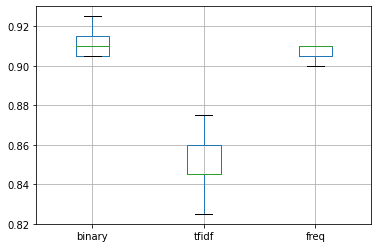

In [6]:
modes = ['binary', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
    end = time.time()
    print("Runtime (",mode,")", "{0:.2f}".format((end - start)), 'sec')
# summarize results
print("\n")
print(results.describe())
# plot results
results.boxplot()

### 2. Second Model: CNN with Word2Vec Embedding

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [8]:
# define model
grid = [5, 10, 15, 20]

for i in grid:
    model = Sequential()
    model.add(Embedding(vocab_size, i, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    start = time.time()
    model.fit(Xtrain, ytrain, epochs=50, verbose=0)
    # evaluate
    loss, acc = model.evaluate(Xtest, ytest, verbose=0)
    print('Test Accuracy: %f' % (acc*100))
    end = time.time()
    print("Runtime (Word2Vec):", "{0:.2f}".format((end - start)), 'sec')

Test Accuracy: 79.000002
Runtime (Word2Vec): 109.85 sec
Test Accuracy: 85.500002
Runtime (Word2Vec): 135.48 sec
Test Accuracy: 86.000001
Runtime (Word2Vec): 174.81 sec
Test Accuracy: 84.500003
Runtime (Word2Vec): 186.28 sec


### 3. Report:
We constructed our corpus with training data set (90% of the data) handling tokenization, lemmatization with NLTK package and dropped the terms that appear only once in the documents to remove noise.  
**For our first model,** we used back-of-words to verctorize documents and constructed simple MLP. In order to select the optimal scoring method, we trained the model with binary, tfidf, and frequency methods. Also, since simple MLP may produce significantly different results in terms of evaluation metric, we trained the model 5 times for each scoring method and calculated statistic (mean accuracy, spread, and runtime) for careful comparison. We chose to have 50 nodes and Relu as the activation in the hidden layer because Relu is computationally efficient and the sigmoid for the output layer because the sigmoid is usually powerful in binary classification. As a result, binary scoring method turned out to be the best among the three metohds, for it produced the highest average accuracy score. Although, frequency scoring method also produced as a high average as the binary and showed lower variation, but its computional cost seems to be noticeably higher for its slight advantage over the binary method. Since the size of our training samples was only 1800, it should be reasonable to give importance to the runtime, so we think that the binary scoring can be the best method for the BoW model for this case.
**For our second model,** we chose to construct CNN with Word2Vec with the expectation that the accuracy score can improve significantly with capturing spatial relationship of the words. We used grid-search method to try several dimensions for embedding (5, 10, 15, 20). CNN is construced with Relu activation for the hidden layer and the sigmoid for the output layer for easier understanding of comparison with our first model since activation function can have a large impact on the results. The result didn't match our exectation because the model produces significantly lower test accuracy than that of our first model. We can try to improve the model by changing dimensions for embedding, the number of layers and the number of nodes in the hidden layer, or activation functions; howevver, **based on the current results,** we conclude that the simple MLP with BoW can be a better choice for this case. A possible reason we can think of is that for this sentiment analysis of binary classification, relationships between words (or context) may not play a significant role for identifying positive or negative signals. For example, capturing terms with positive meanings, such as wonderful, exciting, or inspring which are not usually written with negative helping verbs, can be just enough to predict the correct label.     

# Part 2. Topic Modeling

In [9]:
from nltk import word_tokenize, pos_tag, FreqDist
import seaborn as sns
%matplotlib inline

In [10]:
doc = train_docs + test_docs
print(len(doc))

2000


In [11]:
texts = pd.Series(doc).apply(lambda x: x.split())
print(texts[1])

['happy', 'bastard', 'quick', 'movie', 'review', 'damn', 'bug', 'got', 'head', 'start', 'movie', 'starring', 'jamie', 'lee', 'curtis', 'another', 'baldwin', 'brother', 'william', 'time', 'story', 'regarding', 'crew', 'tugboat', 'come', 'across', 'deserted', 'russian', 'tech', 'ship', 'strangeness', 'kick', 'power', 'back', 'little', 'know', 'power', 'within', 'going', 'gore', 'bringing', 'action', 'sequence', 'virus', 'still', 'feel', 'empty', 'like', 'movie', 'going', 'flash', 'substance', 'dont', 'know', 'crew', 'really', 'middle', 'nowhere', 'dont', 'know', 'origin', 'took', 'ship', 'big', 'pink', 'flashy', 'thing', 'hit', 'mir', 'course', 'dont', 'know', 'donald', 'sutherland', 'stumbling', 'around', 'drunkenly', 'throughout', 'hey', 'let', 'chase', 'people', 'around', 'robot', 'acting', 'average', 'even', 'like', 'curtis', 'youre', 'likely', 'get', 'kick', 'work', 'halloween', 'sutherland', 'wasted', 'baldwin', 'well', 'he', 'acting', 'like', 'baldwin', 'course', 'real', 'star', '

In [12]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

unable to import 'smart_open.gcs', disabling that module


In [13]:
bigram = gensim.models.Phrases(texts, min_count=5, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
dic = [bigram_mod[i] for i in texts]

In [14]:
dictionary = corpora.Dictionary(dic)
doc_term_matrix = [dictionary.doc2bow(i) for i in dic]

In [15]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100, update_every=1, chunksize=100, passes=50)

In [16]:
lda_model.print_topics()

[(0,
  '0.009*"film" + 0.005*"american" + 0.004*"war" + 0.004*"action" + 0.003*"also" + 0.003*"men" + 0.003*"king" + 0.003*"story" + 0.003*"political" + 0.002*"however"'),
 (1,
  '0.009*"comedy" + 0.007*"funny" + 0.005*"disney" + 0.004*"kid" + 0.004*"scream" + 0.004*"joke" + 0.003*"high_school" + 0.003*"laugh" + 0.003*"song" + 0.003*"humor"'),
 (2,
  '0.013*"film" + 0.006*"alien" + 0.004*"human" + 0.004*"world" + 0.004*"one" + 0.003*"special_effect" + 0.003*"ship" + 0.003*"new" + 0.002*"star_war" + 0.002*"series"'),
 (3,
  '0.010*"life" + 0.007*"film" + 0.005*"character" + 0.005*"story" + 0.005*"one" + 0.004*"love" + 0.003*"performance" + 0.003*"man" + 0.003*"wife" + 0.003*"woman"'),
 (4,
  '0.025*"film" + 0.020*"movie" + 0.014*"one" + 0.009*"character" + 0.008*"like" + 0.007*"get" + 0.006*"make" + 0.006*"time" + 0.006*"even" + 0.006*"good"')]

In [17]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\alee8\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.217957  0.110041       1        1  52.043385
3      0.115998  0.064912       2        1  16.900263
2      0.029584 -0.113162       3        1  14.174899
0     -0.088329 -0.241714       4        1   8.983899
1     -0.275210  0.179923       5        1   7.897560, topic_info=     Category          Freq            Term         Total  loglift  logprob
134   Default   6578.000000           movie   6578.000000  30.0000  30.0000
112   Default   1634.000000            life   1634.000000  29.0000  29.0000
79    Default  10782.000000            film  10782.000000  28.0000  28.0000
493   Default    653.000000          comedy    653.000000  27.0000  27.0000
1227  Default    716.000000           funny    716.000000  26.0000  26.0000
95    Default   2004.000000            good   2004.000000  25.0000  25.0000
88    Default   2384.000000             get   2384.000000  24.0000  24.0000
24    Default   3447.000000       character   3447.000000  23.0000  23.0000
226   Default   1551.000000            well   1551.000000  22.0000  22.0000
857   Default    495.000000           alien    495.000000  21.0000  21.0000
206   Default   1491.000000           thing   1491.000000  20.0000  20.0000
166   Default   1332.000000          really   1332.000000  19.0000  19.0000
108   Default    478.000000             kid    478.000000  18.0000  18.0000
113   Default   2843.000000            like   2843.000000  17.0000  17.0000
1707  Default    722.000000          action    722.000000  16.0000  16.0000
65    Default   2192.000000            even   2192.000000  15.0000  15.0000
1627  Default    823.000000            love    823.000000  14.0000  14.0000
232   Default    932.000000           world    932.000000  13.0000  13.0000
922   Default    464.000000           human    464.000000  12.0000  12.0000
273   Default   1082.000000            know   1082.000000  11.0000  11.0000
1245  Default    367.000000           laugh    367.000000  10.0000  10.0000
312   Default    365.000000        american    365.000000   9.0000   9.0000
295   Default   1921.000000           story   1921.000000   8.0000   8.0000
502   Default    246.000000          disney    246.000000   7.0000   7.0000
1386  Default    629.000000          family    629.000000   6.0000   6.0000
1237  Default    320.000000           humor    320.000000   5.0000   5.0000
1244  Default    300.000000            joke    300.000000   4.0000   4.0000
177   Default   1652.000000             see   1652.000000   3.0000   3.0000
3     Default   1974.000000            also   1974.000000   2.0000   2.0000
803   Default    359.000000  special_effect    359.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
1606   Topic5    171.142517     high_school    177.551926   2.5018  -5.6781
8200   Topic5     47.453632            twin     49.158939   2.5033  -6.9608
493    Topic5    433.167786          comedy    653.730835   2.1270  -4.7494
5646   Topic5    107.538216             bob    128.456787   2.3609  -6.1427
468    Topic5    109.410645       animation    131.641769   2.3536  -6.1255
3824   Topic5    197.720123          scream    281.954987   2.1837  -5.5337
5978   Topic5    149.384232       hilarious    211.100189   2.1928  -5.8140
4373   Topic5     75.692413         college     89.309341   2.3732  -6.4939
604    Topic5    165.108337            song    254.278564   2.1068  -5.7140
1227   Topic5    355.011871           funny    716.486694   1.8364  -4.9484
6590   Topic5    139.085571           comic    212.230286   2.1160  -5.8855
1244   Topic5    177.807114            joke    300.143311   2.0151  -5.6399
2125   Topic5     81.039185         wedding    103.155296   2.2973  -6.4256
2370   Topic5    163.443054           voice    283.045410   1.9895  -5.7241
1304   Topic5     97.090034             toy    135.192413   2.2076  -6.2449
564    

### Report:

**Our approach** was to construct bigram for the terms that appear 10 or more times together in order to capture contextual meanings that can enabl us to better interpret the result. We chose to see top 5 topics for the given documents with LDA model from gensim package. We tried to interpret the result as the following based on the top-30 words for the top 3 topics:  
**Topic 1:** (People) would like the movie (film) with even one good scene or good character (actor).  
**Topic 2:** (People) find film (about) life story (or) love between man and woman (or) family (or) child.    
**Topic 3:** audience (may like) film (about) alien and human (like) star_war series or horror (of) evil (or) vampire (that include) special effect and much action.  
The subjective interpretation of the combinations of top words could be vice versa or not sufficiently related to the true data, but as long as we can get a good understanding of two possible and opposing scenarios for this case (positive or negative sentiment), we can further discuss business strategies to make positive impacts from the data. 